<h2>SQL</h2>
In this notebook, I used a sample database which includes music track sales, employee, and customer information in multiple tables (the database file is chinook.db). By using both SQL queries and python commands, I looked into the followings.

<ol>
    <li>The most popular genre</li>
    <li>The sales support agent who contributes to the sales the most</li>
    <li>The customer information for each country</li>
    <li>The trend of music track purchase</li>
</ol>

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
def show_tables():
    q = '''
    SELECT
        name, 
        type 
    FROM sqlite_master 
    WHERE type IN ("table","view");
    '''
    return run_query(q)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


<h3>1. Popular genre</h3>

In [6]:
q = '''
WITH 
    track_genre AS
        (
        SELECT 
            g.name genre,
            t.track_id
        FROM genre g
        INNER JOIN track t
        ON t.genre_id = g.genre_id
        ),
    
    invoice_track_genre AS
        (
        SELECT
            i.track_id,
            tg.genre
        FROM invoice_line i
        LEFT JOIN track_genre tg
        ON i.track_id = tg.track_id
        )

SELECT
    genre,
    COUNT(genre) Number_of_tracks,
    COUNT(genre)*1.0/(SELECT COUNT(*) FROM invoice_track_genre) Percentage
FROM invoice_track_genre
GROUP BY genre
ORDER BY Percentage DESC
;
'''
run_query(q)

,genre,Number_of_tracks,Percentage
0,Rock,2635,0.553921
1,Metal,619,0.130124
2,Alternative & Punk,492,0.103427
3,Latin,167,0.035106
4,R&B/Soul,159,0.033424
5,Blues,124,0.026067
6,Jazz,121,0.025436
7,Alternative,117,0.024595
8,Easy Listening,74,0.015556
9,Pop,63,0.013244


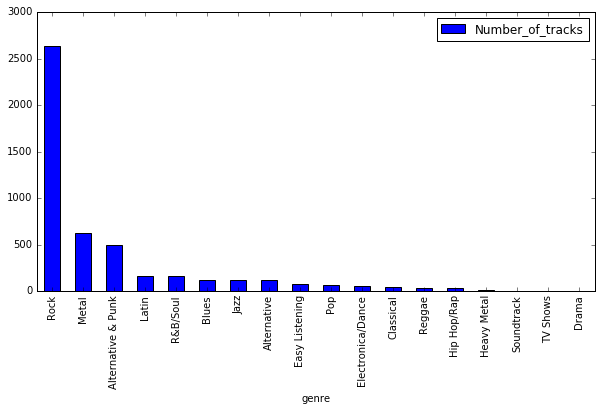

In [7]:
genre_sales_usa = run_query(q)
genre_sales_usa = genre_sales_usa.set_index("genre")
genre_sales_usa.plot(kind="bar", y="Number_of_tracks", 
                     rot=90, figsize=(10,5))

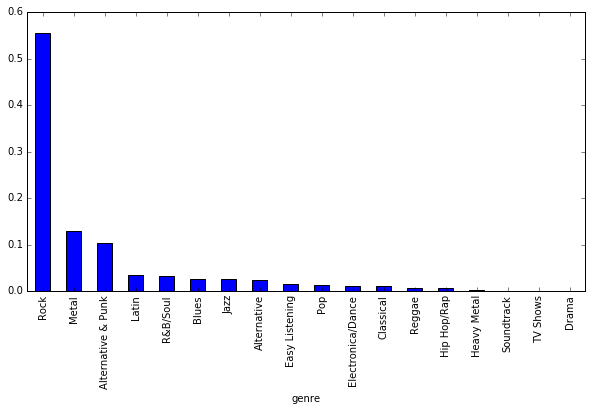

In [8]:
genre_sales_usa["Percentage"].plot(kind="bar",
                                rot=90, figsize=(10,5))

Findings
<ul>
    <li>The sales of Rock music is more than half of the tolal seles.</li>
    <li>Metal and Alternative & Punk music are ppular after Rock music.</li>
    <li>Tracks in TV shows. Drama, and Soundtrack are not popular.</li>
</ul>

<h3>2. Performance for each sales support agent</h3>

In [9]:
q = '''
WITH Sales_per_Employee AS
    (SELECT 
        e.employee_id,
        e.first_name || ' ' || e.last_name Name,
        e.title,
        e.hire_date,
        e.birthdate,
        c.customer_id,
        i.total Total
    FROM employee e
    LEFT JOIN customer c
    ON e.employee_id = c.support_rep_id
    LEFT JOIN invoice i
    ON c.customer_id = i.customer_id
    WHERE title = "Sales Support Agent")

SELECT
    employee_id,
    Name,
    birthdate,
    hire_date,
    SUM(Total) Sales
FROM Sales_per_Employee
GROUP BY employee_id
ORDER BY Sales Desc
;
'''
run_query(q)

,employee_id,Name,birthdate,hire_date,Sales
0,3,Jane Peacock,1973-08-29 00:00:00,2017-04-01 00:00:00,1731.51
1,4,Margaret Park,1947-09-19 00:00:00,2017-05-03 00:00:00,1584.00
2,5,Steve Johnson,1965-03-03 00:00:00,2017-10-17 00:00:00,1393.92


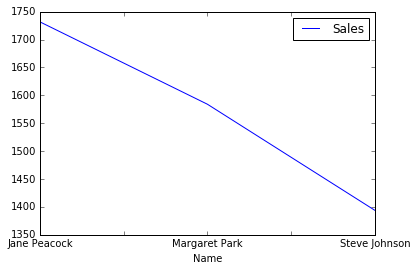

In [10]:
employee_sales = run_query(q)
employee_sales = employee_sales.set_index("employee_id")
employee_sales.plot(x="Name", y="Sales", kind="line")    

Findings
<ul>
    <li>The sales by Jane is the largest of all.</li>
    <li>Jane has worked since 4/1/2017, which is the longest of all.</li>
    <li>Jane is the youngest.</li>
</ul>

Rock, Metal, and Alternamtive & Punk music are popular in the store from the result above. Probably the costomers might be young (20s - 30s), and she is in the same generation as them. Thus she might understand what customers want more than other sales support agents.

<h3>3. Sales data for customers from each different country</h3>

In [11]:
q = '''
    SELECT
        country,
        COUNT(customer_id) number_of_customer
    FROM customer
    GROUP BY country
    ORDER BY 2 ASC
'''
run_query(q)

,country,number_of_customer
0,Argentina,1
1,Australia,1
2,Austria,1
3,Belgium,1
4,Chile,1
5,Denmark,1
6,Finland,1
7,Hungary,1
8,Ireland,1
9,Italy,1


Categorize countries which have only one customer as "Other" and list them in the bottom.

In [12]:
c = '''
CREATE VIEW data_each_country AS
    SELECT
        c.country,
        cc.number_of_customer,
        COUNT(i.invoice_id) Total_invoice,
        SUM(i.total) Total_sales
    FROM customer c
    INNER JOIN invoice i
    ON c.customer_id = i.customer_id
    LEFT JOIN (
        SELECT
        country,
        COUNT(customer_id) number_of_customer
        FROM customer
        GROUP BY country
        ORDER BY 2 ASC
    ) cc
    ON cc.country = c.country
    GROUP BY 1
    ORDER BY 1
'''
run_command(c)

In [13]:
q = '''
    SELECT * FROM data_each_country
    LIMIT 10
;
'''
run_query(q)

,country,number_of_customer,Total_invoice,Total_sales
0,Argentina,1,5,39.60
1,Australia,1,10,81.18
2,Austria,1,9,69.30
3,Belgium,1,7,60.39
4,Brazil,5,61,427.68
5,Canada,8,76,535.59
6,Chile,1,13,97.02
7,Czech Republic,2,30,273.24
8,Denmark,1,10,37.62
9,Finland,1,11,79.20


In [14]:
q = '''
    SELECT
        country,
        number_of_customer,
        Total_sales,
        Total_sales/number_of_customer ave_sales_per_customer,
        Total_invoice*1.0/number_of_customer ave_order
    FROM (
        SELECT
            dc.*,
            CASE
                WHEN dc.number_of_customer = 1 THEN 1
                ELSE 0
            END AS sort
        FROM data_each_country dc
        )
    ORDER BY sort ASC, Total_sales DESC
;
'''
run_query(q)

,country,number_of_customer,Total_sales,ave_sales_per_customer,ave_order
0,USA,13,1040.49,80.037692,10.076923
1,Canada,8,535.59,66.948750,9.500000
2,Brazil,5,427.68,85.536000,12.200000
3,France,5,389.07,77.814000,10.000000
4,Germany,4,334.62,83.655000,10.250000
5,Czech Republic,2,273.24,136.620000,15.000000
6,United Kingdom,3,245.52,81.840000,9.333333
7,Portugal,2,185.13,92.565000,14.500000
8,India,2,183.15,91.575000,10.500000
9,Ireland,1,114.84,114.840000,13.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1be5facbe0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f1be5e6a828>], dtype=object)

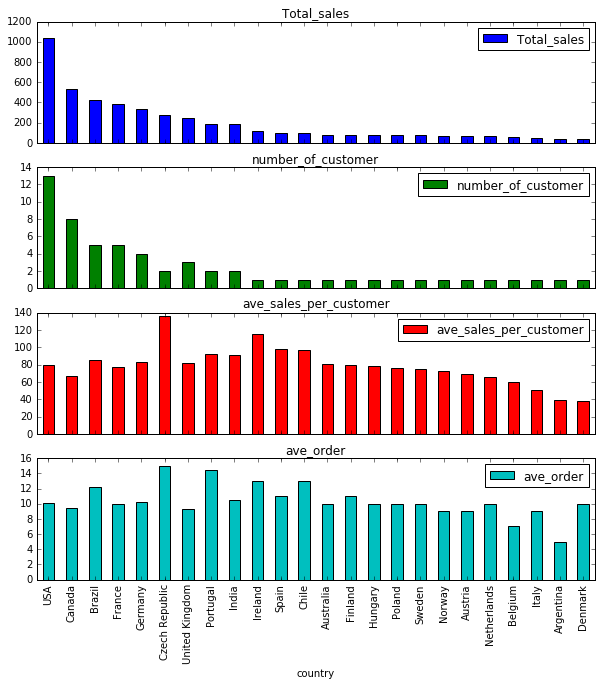

In [15]:
sales_country = run_query(q)

sales_country.plot(x="country",
                   y=["Total_sales","number_of_customer",
                      "ave_sales_per_customer", "ave_order"], 
                   kind="bar", figsize=(10,10), subplots=True)

Findings
<ul>
    <li>The number of order for each country is almost same.</li>
    <li>The number of average sales per customer for each country is almost same except Czech Republic.</li>
    <li>Average sales per customer for Czech Republic is almost twice as other countries.</li>
</ul>
Because of the findings, total sales has arelationship with the number of customers. Thus USA is a prominent country for more sales growth. In addition to this, since its average sales per customer is big, Czech Republic could be also a prominent country. (More data is needed.)

<h3>4. Purchaces of individual tracks vs tracks as an album</h3>

In [16]:
q = '''
    SELECT
        COUNT(DISTINCT invoice_id)
    FROM invoice_line
;
'''
run_query(q)

,COUNT(DISTINCT invoice_id)
0,614


From above, there are 614 unique invoice IDs. I will check whether each invoice includes one album ID or not.

In [17]:
# Create a View including invoice_id, track_id, and album_id.

c = '''
CREATE VIEW invoices AS
    SELECT
        i.invoice_id,
        t.track_id,
        t.album_id
    FROM invoice_line i
    INNER JOIN track t
    ON i.track_id = t.track_id
;
'''
run_command(c)

In [18]:
q = '''
    SELECT * FROM invoices
;'''
invoices = run_query(q)
run_query(q).head()

,invoice_id,track_id,album_id
0,1,1158,91
1,1,1159,91
2,1,1160,91
3,1,1161,91
4,1,1162,91


In [19]:
# Create a View including track_id and album_id.

c = '''
CREATE VIEW tracks AS
    SELECT
        t.track_id,
        a.album_id
    FROM track t
    LEFT JOIN album a
    ON t.album_id = a.album_id 
;
'''
run_command(c)

In [20]:
q = '''
    SELECT * FROM tracks
    WHERE album_id = 91
;
'''
run_query(q)

,track_id,album_id
0,1158,91
1,1159,91
2,1160,91
3,1161,91
4,1162,91
5,1163,91
6,1164,91
7,1165,91
8,1166,91
9,1167,91


From above, an invoice (ID = 1) might be a purchace of tracks as an album. Thus, for instance, I will compare a table with invoice ID = 1 to a table with album_id = 91.

In [21]:
# If two tables are identical, 1 will be assinged to judge column.
# If not, 0 will be assigned.

q = '''
    SELECT
    invoice_id,
        CASE 
            WHEN(
                (
                SELECT track_id FROM invoices
                WHERE invoice_id = 1
                EXCEPT
                SELECT track_id FROM tracks
                WHERE album_id = 91
                ) IS NULL
                AND
                (
                SELECT track_id FROM tracks
                WHERE album_id = 91
                EXCEPT
                SELECT track_id FROM invoices
                WHERE invoice_id = 1
                ) IS NULL
            ) THEN 1
        ELSE 0
        END AS judge
    FROM invoices
    GROUP BY invoice_id
    HAVING invoice_id = 1
;
'''
run_query(q)

,invoice_id,judge
0,1,1


The invoice (invoice_id = 1) is a whole album sales.<br>
To check all the invoices, get a list of album_id for each invoice.

In [22]:
# Create a function to check if two tables are identical or not.

def check_tracks(invoice_id, album_id):
    invoice_id = str(invoice_id)
    album_id = str(album_id)
    
    q = '''
            SELECT
        invoice_id,
        CASE 
            WHEN(
                (
                SELECT track_id FROM invoices
                WHERE invoice_id = ''' + invoice_id + '''
                EXCEPT
                SELECT track_id FROM tracks
                WHERE album_id = ''' + album_id + '''
                ) IS NULL
                AND
                (
                SELECT track_id FROM tracks
                WHERE album_id = ''' + album_id + '''
                EXCEPT
                SELECT track_id FROM invoices
                WHERE invoice_id = ''' + invoice_id + '''
                ) IS NULL
            ) THEN 1
        ELSE 0
        END AS judge
    FROM invoices
    GROUP BY invoice_id
    HAVING invoice_id = ''' + invoice_id + '''
    ;
    '''
    return run_query(q)
    

In [23]:
# Check if the function works properly.

check_tracks(1,91)

,invoice_id,judge
0,1,1


In [24]:
# use a for loop for each invoice ID and check if it is about a purchace of a whole album.
# If it is an album sales, add the invoice id in a list.

album_purchace = []

for i in range(1,615):
    
    album_ids = invoices[invoices["invoice_id"] == i]["album_id"].unique().tolist()
    
    if len(album_ids) == 1:
        result = check_tracks(i, album_ids[0])
        if result.loc[0, "judge"] == 1:
            album_purchace.append(result.loc[0, "invoice_id"])

In [25]:
len(album_purchace)

114

In [26]:
114/614

0.18566775244299674

From above, 114 invoices are album purchaces. And it is about 19% of the total invoices.<br>
Next, I will check the ratio of album purchases.

In [27]:
q = '''
    SELECT
        invoice_id,
        total
    FROM invoice
;
'''
invoice_sales = run_query(q)

In [28]:
is_album = invoice_sales["invoice_id"].isin(album_purchace)
invoice_sales[is_album]["total"].sum()

1461.24

In [29]:
invoice_sales["total"].sum()

4709.4300000000003

In [30]:
invoice_sales[is_album]["total"].sum() / invoice_sales["total"].sum()

0.31027958797561489

From above, the sales of album purchace is $1461 and this is 30% of the total sales. If the ratio of album purchaces is increasing, it would be better to focus on album sales.